<a href="https://colab.research.google.com/github/dwu926/Problem-Management-UI/blob/master/E_commerce_Purchase_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving online_shopping_data.csv to online_shopping_data (1).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV, SGDClassifier
from sklearn import svm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,RobustScaler,LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import pickle

from collections import Counter
from sklearn.utils import resample

from IPython.display import display
pd.set_option('display.max_columns', 60)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('fivethirtyeight')

import random
random.seed(9001)

In [32]:
data = pd.read_csv('online_shopping_data.csv')
df = data.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Prep analysis the data`

In [33]:
# checking if any of the attributes are empty 
pd.DataFrame({'Count_Missing' : df.isnull().sum(), 'Percentage_Missing' : 100*df.isnull().sum()/len(df)}).sort_values(by = ['Count_Missing'], ascending=False).head(20)

,Count_Missing,Percentage_Missing
Administrative,0,0.0
Administrative_Duration,0,0.0
Weekend,0,0.0
VisitorType,0,0.0
TrafficType,0,0.0
Region,0,0.0
Browser,0,0.0
OperatingSystems,0,0.0
Month,0,0.0
SpecialDay,0,0.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [35]:
# checking all the unstructured data
print(Counter(df['Month']))
print(Counter(df['VisitorType']))
print(Counter(df['Weekend']))
print(Counter(df['Revenue']))

Counter({'May': 3364, 'Nov': 2998, 'Mar': 1907, 'Dec': 1727, 'Oct': 549, 'Sep': 448, 'Aug': 433, 'Jul': 432, 'June': 288, 'Feb': 184})
Counter({'Returning_Visitor': 10551, 'New_Visitor': 1694, 'Other': 85})
Counter({False: 9462, True: 2868})
Counter({False: 10422, True: 1908})


In [36]:
# checking all the structured data
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


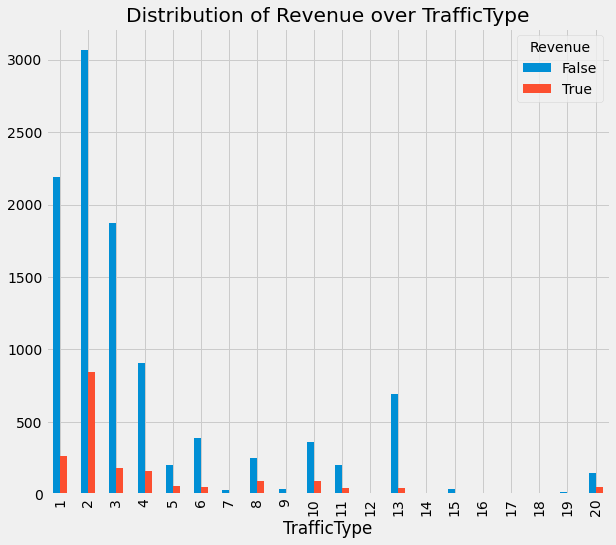

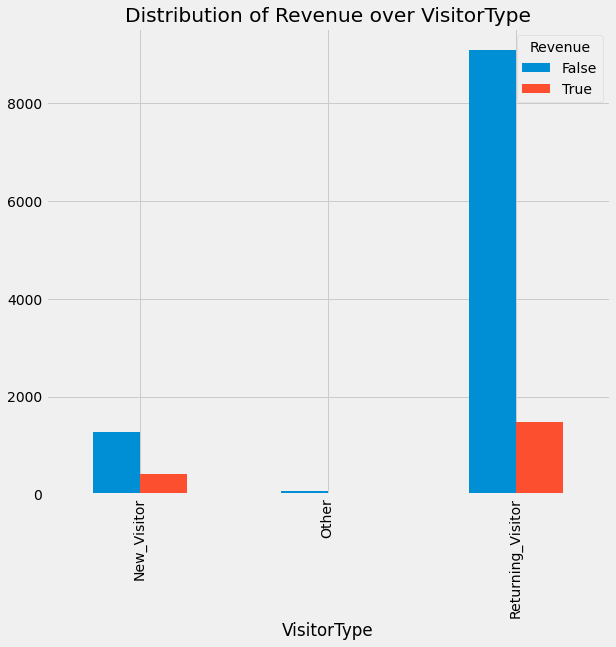

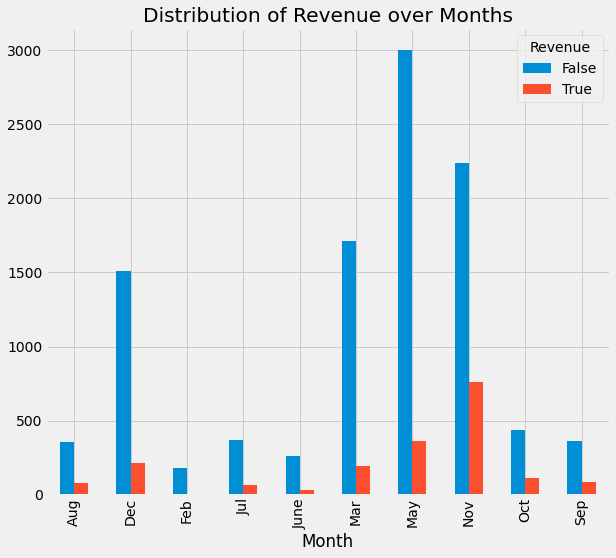

In [37]:
# making some plots to get some insight about the affection of different attributes to the purchase

pd.crosstab(df['TrafficType'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over TrafficType")

pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over VisitorType")

pd.crosstab(df['Month'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over Months")

plt.show()

# Preprocessing the data and ready for modeling
# Feature Engineering

In [38]:
# using dummy/One Hot Encoding
df = pd.get_dummies( df, columns = ['VisitorType','Month'])
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


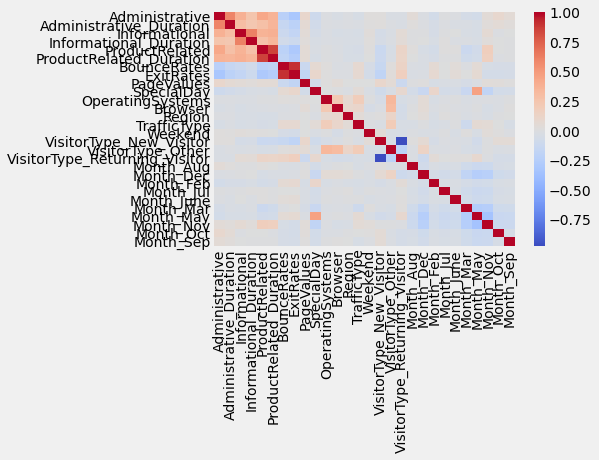

In [39]:
# Checking for Collinearity Between Features
X = df.drop('Revenue', axis=1)
Y = df['Revenue']
corr_coeff = X.corr()
sns.heatmap(corr_coeff, xticklabels=corr_coeff.columns,yticklabels=corr_coeff.columns, cmap='coolwarm')

Looks like there are some correlation between 

1.   "Administrative", "Administrative Duration"
2.   "Informational", "Informational Duration"
3.    "Product Related" and
"Product Related Duration" 

So we can reduec the features by generating new features such as (AvgAdministrativeDuration = Administrative Duration / Administrative)




,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,AvgAdminDura,AvgInformDura,AvgProdDura,VisitRate
0,0.0,0.0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.000000,1.000000
1,0.0,0.0,2,2,1,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,32.000000,0.000000
2,0.0,0.0,4,1,9,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.000000,1.000000
3,0.0,0.0,3,2,2,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1.333333,0.357143
4,0.0,0.0,3,3,1,4,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,62.750000,0.400000


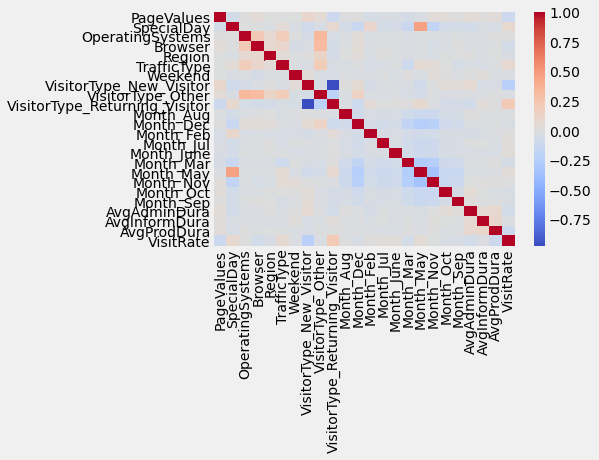

In [40]:
n = len(df)
def avgdura(duration, count):
  if count != 0:
    return duration/count
  else:
    return 0
  
X["AvgAdminDura"] = [avgdura(X['Administrative_Duration'][i], X['Administrative'][i]) for i in range(n)]
X["AvgInformDura"] = [avgdura(X['Informational_Duration'][i], X['Informational'][i]) for i in range(n)]
X["AvgProdDura"] = [avgdura(X['ProductRelated_Duration'][i], X['ProductRelated'][i]) for i in range(n)]
X["VisitRate"] = [avgdura(X['BounceRates'][i], X['ExitRates'][i]) for i in range(n)]

X.drop(['Administrative', 'Administrative_Duration','Informational', 
        'Informational_Duration','ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates'],axis = 1, inplace = True)
X.head()
corr_coeff = X.corr()
sns.heatmap(corr_coeff, xticklabels=corr_coeff.columns,yticklabels=corr_coeff.columns, cmap='coolwarm')


In [41]:
# Define a function for model evaluation:

def model_eval(y_test,y_pred):

    acc = accuracy_score(y_test,y_pred,normalize=True)
    num_acc = accuracy_score(y_test,y_pred,normalize=False)
    prec = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1_score =  f1_score(y_test,y_pred)
    auc_score = roc_auc_score(y_test,y_pred)
        
    return{'Accuracy:': acc,
           'Accuracy_count:': num_acc,
           'Precision:': prec,
           'Recall:': recall,
           'F1_score:':F1_score,
           'AUC_ROC:':auc_score}

def compare_result(train_summary, test_summary):
    print()
    print('Train data:-')
    for score in train_summary:
        print(score,train_summary[score])
    
    print()
    print('Test data:-')
    for score in test_summary:
      print(score,test_summary[score])

def roc_auc(model, y_train, x_train, y_test, x_test):

    plt.figure(figsize=(8,6))    
    logit_roc_auc1 = roc_auc_score(y_train, model.predict(x_train))
    fpr1, tpr1, thresholds1 = roc_curve(y_train, model.predict_proba(x_train)[:,1])
    plt.plot(fpr1, tpr1, label='Class_Train (AUC = %0.2f)' % logit_roc_auc1)
        
    logit_roc_auc2 = roc_auc_score(y_test, model.predict(x_test))
    fpr2, tpr2, thresholds2 = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    plt.plot(fpr2, tpr2,label='Class_Test (AUC = %0.2f)' % logit_roc_auc2)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic(ROC-AUC)')
    plt.legend(loc="lower right")
    plt.show()




In [42]:
X.describe()
# it looks like some features might have some wild range and outliner so the following normalization I will use RobustScaler() from Sklearn library

,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,AvgAdminDura,AvgInformDura,AvgProdDura,VisitRate
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586,0.232603,0.137388,0.006894,0.855718,0.035118,0.140065,0.014923,0.035036,0.023358,0.154663,0.272830,0.243147,0.044526,0.036334,20.196282,14.807761,37.633690,0.292310
std,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169,0.422509,0.344271,0.082745,0.351390,0.184084,0.347068,0.121250,0.183880,0.151043,0.361598,0.445432,0.429000,0.206268,0.187128,45.995553,65.551312,44.767916,0.355184
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.613281,0.000000
50%,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.091667,0.000000,28.878189,0.171721
75%,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,24.360119,0.000000,45.084444,0.500000
max,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1566.600000,1778.000000,1411.000000,4.750000


# Feature selection and choosing the most relevant ones

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

list_one =[]
feature_ranking = SelectKBest(chi2, k=10)
fit = feature_ranking.fit_transform(X, Y)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
pd.DataFrame(list_one).sort_values(by=[0], ascending = False)


,0,1
0,175126.808512,PageValues
21,10662.599140,AvgInformDura
20,6829.412944,AvgAdminDura
22,1143.263922,AvgProdDura
17,223.548231,Month_Nov
7,115.339482,VisitorType_New_Visitor
23,84.415852,VisitRate
16,54.997108,Month_May
1,53.797094,SpecialDay
15,42.613274,Month_Mar


In [44]:
# drop all the features that has score < 1.0
X .drop(['VisitorType_Other','Month_Jul'],axis=1,inplace=True)

In [45]:
# generate the train and test test data split and the standarization of each features:

X_copy = X.copy()
scaler = RobustScaler()
X_standarized = scaler.fit_transform(X_copy)

x_train,x_test,y_train,y_test = train_test_split(X_standarized,Y,test_size=0.2,random_state=0)

# Logistic Regression

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Train data:-
Accuracy: 0.8673965936739659
Accuracy_count: 8556
Precision: 0.5446339017051154
Recall: 0.730820995962315
F1_score: 0.6241379310344827
AUC_ROC: 0.8112209539372329

Test data:-
Accuracy: 0.8540145985401459
Accuracy_count: 2106
Precision: 0.5593869731800766
Recall: 0.6919431279620853
F1_score: 0.6186440677966101
AUC_ROC: 0.7897093330612774


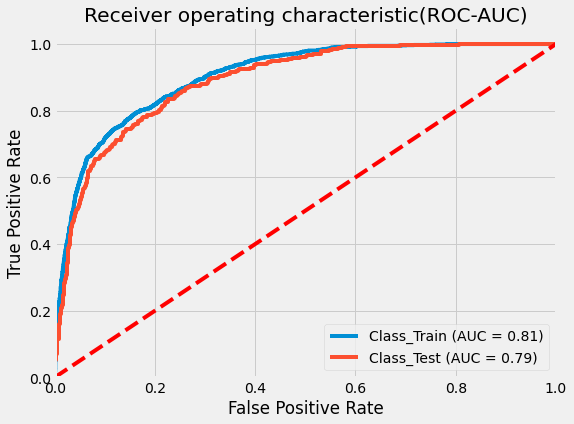

In [46]:
# Note the optimization (solver) and regular and balanced the class weight has been adjust for optimal performance.
model = LogisticRegression(solver='liblinear',random_state=7, penalty='l1', class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

train_summary = model_eval(y_train,y_pred_train)
test_summary = model_eval(y_test,y_pred)

compare_result(train_summary, test_summary)
roc_auc(model, y_train, x_train, y_test, x_test)

# Logistic Regression with cross validation



LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l1', random_state=7, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)


Train data:-
Accuracy: 0.8933495539334956
Accuracy_count: 8812
Precision: 0.6291666666666667
Recall: 0.7113055181695828
F1_score: 0.6677195198989261
AUC_ROC: 0.8184720476978253

Test data:-
Accuracy: 0.8807785888077859
Accuracy_count: 2172
Precision: 0.6434977578475336
Recall: 0.6800947867298578
F1_score: 0.6612903225806452
AUC_ROC: 0.8011530685116999


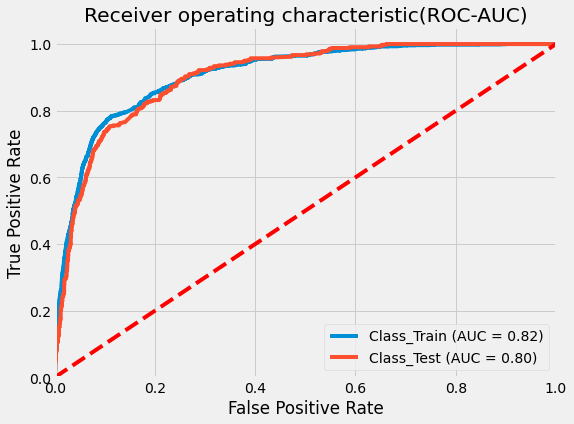

In [47]:
model = LogisticRegressionCV(cv=5, solver='liblinear',random_state=7, penalty='l1', class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

train_summary = model_eval(y_train,y_pred_train)
test_summary = model_eval(y_test,y_pred)

compare_result(train_summary, test_summary)
roc_auc(model, y_train, x_train, y_test, x_test)

# Support Vertor Machines Model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
    verbose=False)


Train data:-
Accuracy: 0.8918288726682887
Accuracy_count: 8797
Precision: 0.6224430157802455
Recall: 0.7166890982503364
F1_score: 0.6662496090084454
AUC_ROC: 0.8197911951027285

Test data:-
Accuracy: 0.8799675587996756
Accuracy_count: 2170
Precision: 0.640625
Recall: 0.6800947867298578
F1_score: 0.6597701149425288
AUC_ROC: 0.8006638317210932


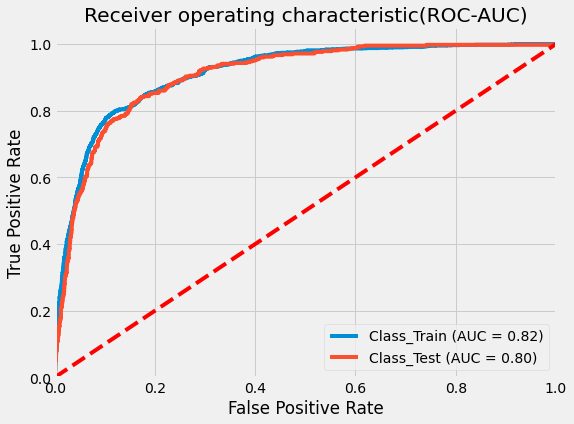

In [48]:
# Note: this model takes much longer time and it is better use GPU and the training time is around 10 minutes and pool for poly kernel and better for linear kernel

model = svm.SVC(random_state = 7, class_weight = 'balanced', kernel = 'linear', probability=True)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

train_summary = model_eval(y_train,y_pred_train)
test_summary = model_eval(y_test,y_pred)

compare_result(train_summary, test_summary)
roc_auc(model, y_train, x_train, y_test, x_test)

# Random Forest Classifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


Train data:-
Accuracy: 0.8938564476885644
Accuracy_count: 8817
Precision: 0.603880738286796
Recall: 0.8586810228802153
F1_score: 0.7090858571825507
AUC_ROC: 0.8793882555317764

Test data:-
Accuracy: 0.8751013787510138
Accuracy_count: 2158
Precision: 0.6055555555555555
Recall: 0.7748815165876777
F1_score: 0.6798336798336797
AUC_ROC: 0.8353370400942302


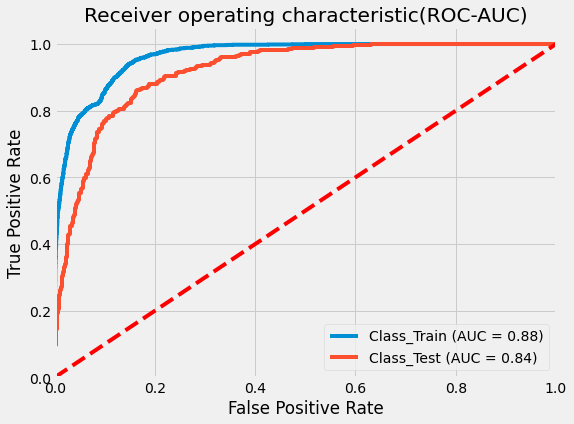

In [63]:
# Note, the Random Forest Classifier so far is the best performed model but the training set can easily get overfitted.
model = RandomForestClassifier(n_estimators= 200, max_depth = 9, random_state=7, class_weight='balanced' )
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

train_summary = model_eval(y_train,y_pred_train)
test_summary = model_eval(y_test,y_pred)

compare_result(train_summary, test_summary)
roc_auc(model, y_train, x_train, y_test, x_test)

# XGBoost Tree model

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Train data:-
Accuracy: 0.9668491484184915
Accuracy_count: 9537
Precision: 0.955940204563336
Recall: 0.8176312247644684
F1_score: 0.8813928182807398
AUC_ROC: 0.9054735259654283

Test data:-
Accuracy: 0.8819951338199513
Accuracy_count: 2175
Precision: 0.7027863777089783
Recall: 0.5379146919431279
F1_score: 0.6093959731543623
AUC_ROC: 0.7454739800224446


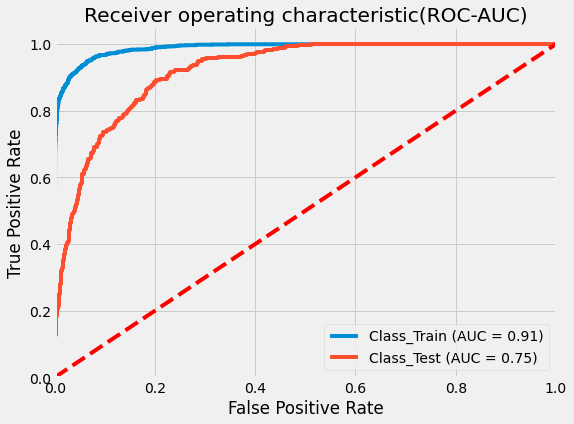

In [66]:
model = XGBClassifier(learning_rate = 0.1, n_estimators=200, min_child_weight=3,  max_depth=7, class_weight='balanced')
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

train_summary = model_eval(y_train,y_pred_train)
test_summary = model_eval(y_test,y_pred)

compare_result(train_summary, test_summary)
roc_auc(model, y_train, x_train, y_test, x_test)